In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import warnings
warnings.filterwarnings('ignore')

print(os.listdir('../data/bank'))

from IPython.display import display

['.DS_Store', 'test.csv', 'output', 'submit_sample.csv', 'train.csv']


In [220]:
df_train = pd.read_csv('../data/bank/train.csv')
df_test = pd.read_csv('../data/bank/test.csv')

In [221]:
def kesson_table(df):
    total = df.isnull().sum()
    percent = total / len(df) * 100
    kesson_table = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    kesson_table = kesson_table.drop(kesson_table[kesson_table['Total']==0].index)
    return kesson_table

In [222]:
kesson_table(df_train)

,Total,Percent


In [223]:
df_train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


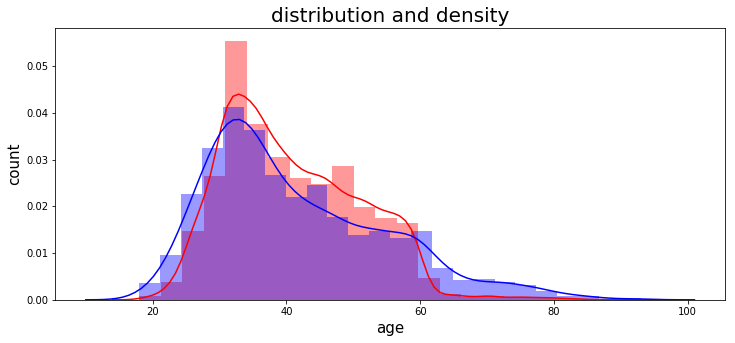

In [224]:
y0 = df_train[df_train['y'] == 0]
y1 = df_train[df_train['y'] == 1]

plt.figure(figsize=(12, 5))

sns.distplot(y0['age'], bins=24, color='r')
sns.distplot(y1['age'], bins=24, color='b')
plt.title('distribution and density', fontsize=20)
plt.xlabel('age', fontsize=15)
plt.ylabel('count', fontsize=15)

plt.show()

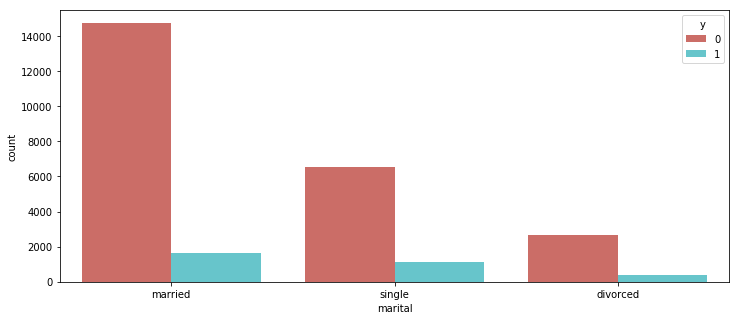

In [225]:
plt.figure(figsize=(12, 5))

sns.countplot(x='marital', hue='y', data=df_train, palette='hls')

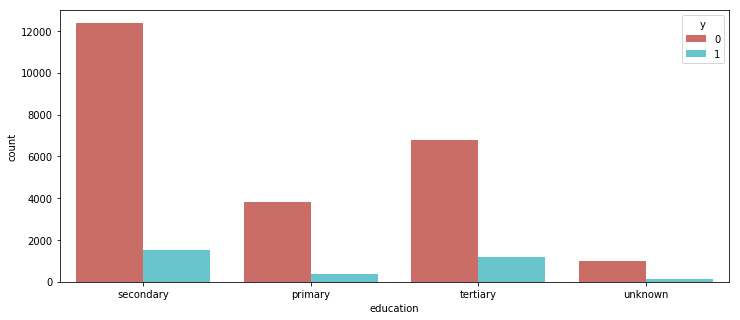

In [226]:
plt.figure(figsize=(12, 5))

sns.countplot(x='education', hue='y', data=df_train, palette='hls')

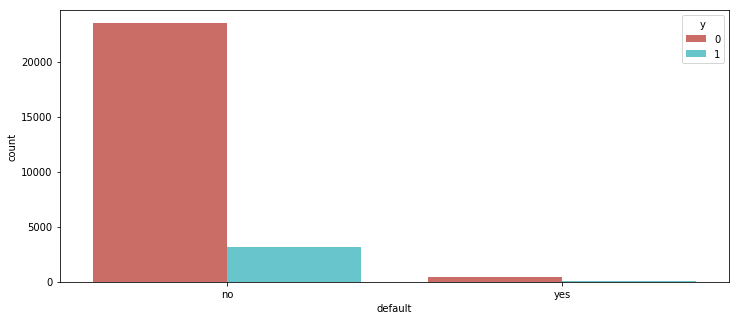

In [227]:
plt.figure(figsize=(12, 5))

sns.countplot(x='default', hue='y', data=df_train, palette='hls')

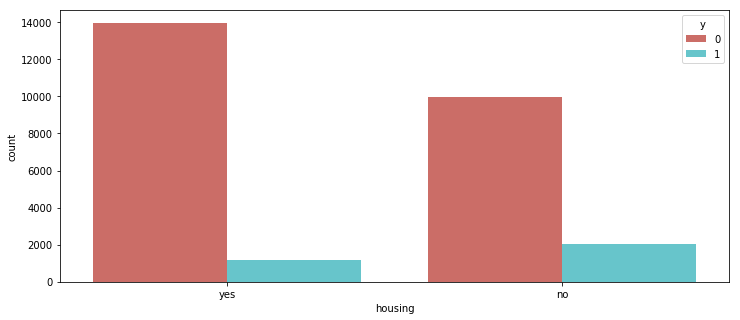

In [228]:
plt.figure(figsize=(12, 5))

sns.countplot(x='housing', hue='y', data=df_train, palette='hls')

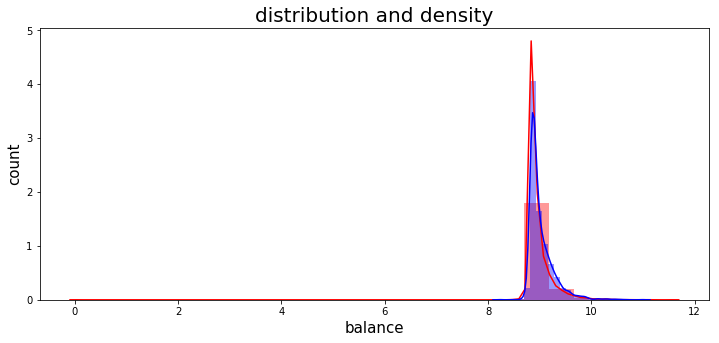

In [229]:
y0 = df_train[df_train['y'] == 0]
y1 = df_train[df_train['y'] == 1]

plt.figure(figsize=(12, 5))

sns.distplot(np.log(y0['balance'] + 6848), bins=24, color='r')
sns.distplot(np.log(y1['balance'] + 6848), bins=24, color='b')
plt.title('distribution and density', fontsize=20)
plt.xlabel('balance', fontsize=15)
plt.ylabel('count', fontsize=15)

plt.show()

In [230]:
df_train['balance'] = np.log(df_train['balance'] + 10000)
df_test['balance'] = np.log(df_test['balance'] + 10000)

interval = (-10000, -450, -230, -96, 72, 449, 1450, 2100, 3100, 5000, 12000)
labels = ['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var10']

df_train['balance'] = pd.cut(df_train['balance'], interval, labels=labels)
df_test['balance'] = pd.cut(df_test['balance'], interval, labels=labels)

interval = (0, 5, 12, 18, 25, 35, 60, 120)

cats = ['Babies', 'Children', 'Teen', 'Student', 'Young', 'Adult', 'Senior']

df_train["age"] = pd.cut(df_train['age'], interval, labels=cats)
df_test['age'] = pd.cut(df_test['age'], interval, labels=cats)

In [231]:
df_train['previous'][df_train['previous'] > 0] = 1
df_test['previous'][df_test['previous'] > 0] = 1

In [232]:
columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome', 'previous']

df_train = pd.get_dummies(df_train, columns=columns, prefix=columns, drop_first=True)
df_test = pd.get_dummies(df_test, columns=columns, prefix=columns, drop_first=True)

In [233]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.layers.recurrent import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
sc = StandardScaler()
mm = MinMaxScaler()

In [234]:
train = df_train.drop(['id', 'y'], axis=1)
train_ = df_train['y']
test = df_test.drop(['id'], axis=1)

X_train = sc.fit_transform(train.values)
y_train = train_.values
X_test = sc.fit_transform(test.values)

#X_train = train.values.astype(np.float32)
#y_train = train_.values.astype(np.float32)
#X_test = test.values.astype(np.float32)

print(X_train.shape, y_train.shape, X_test.shape)

(27128, 42) (27128,) (18083, 42)


In [244]:
model = Sequential()

model.add(Dense(42*5, activation='relu', input_dim=42, kernel_initializer='uniform'))
model.add(Dropout(0.3))
model.add(Dense(42, activation='relu', kernel_initializer='uniform'))
#model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid', kernel_initializer='uniform'))
#model.add(Dropout(0.3))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 210)               9030      
_________________________________________________________________
dropout_21 (Dropout)         (None, 210)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 42)                8862      
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 43        
Total params: 17,935
Trainable params: 17,935
Non-trainable params: 0
_________________________________________________________________


In [246]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=200, batch_size=10000, validation_split=0.2, verbose=1)
print(history.history.keys())

scores = model.evaluate(X_train, y_train, batch_size=30)
print('%s: %.2f%%' % (model.metrics_names[1], scores[1]*100))

Train on 21702 samples, validate on 5426 samples
Epoch 1/200
21702/21702 [==============================] - 1s 68us/step - loss: 0.6925 - acc: 0.5307 - val_loss: 0.6807 - val_acc: 0.8891
Epoch 2/200
21702/21702 [==============================] - 0s 8us/step - loss: 0.6784 - acc: 0.8815 - val_loss: 0.6655 - val_acc: 0.8891
Epoch 3/200
21702/21702 [==============================] - 0s 9us/step - loss: 0.6630 - acc: 0.8815 - val_loss: 0.6472 - val_acc: 0.8891
Epoch 4/200
21702/21702 [==============================] - 0s 9us/step - loss: 0.6439 - acc: 0.8815 - val_loss: 0.6238 - val_acc: 0.8891
Epoch 5/200
21702/21702 [==============================] - 0s 9us/step - loss: 0.6200 - acc: 0.8815 - val_loss: 0.5943 - val_acc: 0.8891
Epoch 6/200
21702/21702 [==============================] - 0s 9us/step - loss: 0.5896 - acc: 0.8815 - val_loss: 0.5584 - val_acc: 0.8891
Epoch 7/200
21702/21702 [==============================] - 0s 10us/step - loss: 0.5531 - acc: 0.8815 - val_loss: 0.5160 - val_ac

21702/21702 [==============================] - 0s 8us/step - loss: 0.2112 - acc: 0.9031 - val_loss: 0.2106 - val_acc: 0.9055
Epoch 61/200
21702/21702 [==============================] - 0s 8us/step - loss: 0.2118 - acc: 0.9037 - val_loss: 0.2102 - val_acc: 0.9055
Epoch 62/200
21702/21702 [==============================] - 0s 8us/step - loss: 0.2103 - acc: 0.9049 - val_loss: 0.2099 - val_acc: 0.9058
Epoch 63/200
21702/21702 [==============================] - 0s 9us/step - loss: 0.2106 - acc: 0.9047 - val_loss: 0.2096 - val_acc: 0.9051
Epoch 64/200
21702/21702 [==============================] - 0s 8us/step - loss: 0.2099 - acc: 0.9042 - val_loss: 0.2094 - val_acc: 0.9045
Epoch 65/200
21702/21702 [==============================] - 0s 8us/step - loss: 0.2090 - acc: 0.9057 - val_loss: 0.2092 - val_acc: 0.9047
Epoch 66/200
21702/21702 [==============================] - 0s 8us/step - loss: 0.2094 - acc: 0.9041 - val_loss: 0.2092 - val_acc: 0.9049
Epoch 67/200
21702/21702 [=====================

21702/21702 [==============================] - 0s 9us/step - loss: 0.1970 - acc: 0.9115 - val_loss: 0.2060 - val_acc: 0.9084
Epoch 120/200
21702/21702 [==============================] - 0s 7us/step - loss: 0.1962 - acc: 0.9131 - val_loss: 0.2061 - val_acc: 0.9082
Epoch 121/200
21702/21702 [==============================] - 0s 10us/step - loss: 0.1958 - acc: 0.9127 - val_loss: 0.2062 - val_acc: 0.9090
Epoch 122/200
21702/21702 [==============================] - 0s 12us/step - loss: 0.1955 - acc: 0.9134 - val_loss: 0.2061 - val_acc: 0.9093
Epoch 123/200
21702/21702 [==============================] - 0s 8us/step - loss: 0.1946 - acc: 0.9143 - val_loss: 0.2060 - val_acc: 0.9080
Epoch 124/200
21702/21702 [==============================] - 0s 8us/step - loss: 0.1942 - acc: 0.9117 - val_loss: 0.2061 - val_acc: 0.9079
Epoch 125/200
21702/21702 [==============================] - 0s 9us/step - loss: 0.1935 - acc: 0.9138 - val_loss: 0.2062 - val_acc: 0.9086
Epoch 126/200
21702/21702 [============

Epoch 178/200
21702/21702 [==============================] - 0s 7us/step - loss: 0.1841 - acc: 0.9194 - val_loss: 0.2094 - val_acc: 0.9067
Epoch 179/200
21702/21702 [==============================] - 0s 7us/step - loss: 0.1839 - acc: 0.9203 - val_loss: 0.2090 - val_acc: 0.9075
Epoch 180/200
21702/21702 [==============================] - 0s 9us/step - loss: 0.1842 - acc: 0.9210 - val_loss: 0.2093 - val_acc: 0.9055
Epoch 181/200
21702/21702 [==============================] - 0s 10us/step - loss: 0.1817 - acc: 0.9216 - val_loss: 0.2095 - val_acc: 0.9055
Epoch 182/200
21702/21702 [==============================] - 0s 7us/step - loss: 0.1816 - acc: 0.9208 - val_loss: 0.2093 - val_acc: 0.9049
Epoch 183/200
21702/21702 [==============================] - 0s 11us/step - loss: 0.1806 - acc: 0.9208 - val_loss: 0.2091 - val_acc: 0.9056
Epoch 184/200
21702/21702 [==============================] - 0s 9us/step - loss: 0.1810 - acc: 0.9217 - val_loss: 0.2091 - val_acc: 0.9056
Epoch 185/200
21702/21702

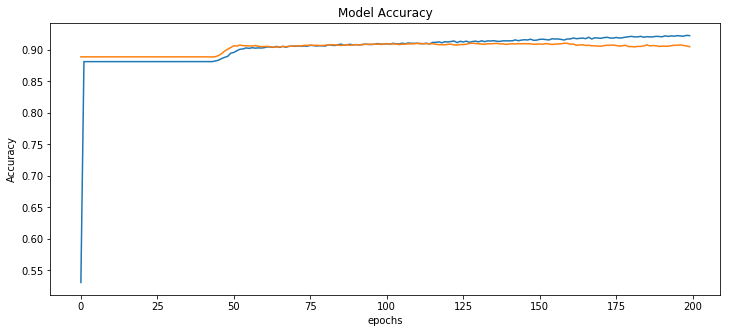

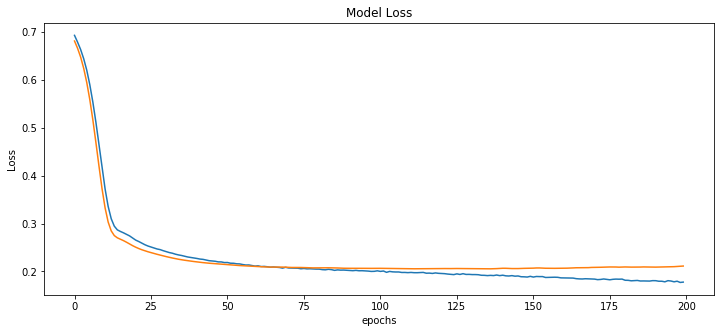

In [247]:
def display():
    """This function display history of acc and loss.
    returns: two figures.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.show()
display()

In [248]:
predict = model.predict(X_test)

df_out = pd.read_csv('../data/bank/test.csv')
df_out['y'] = predict

df_out[['id', 'y']].to_csv('../data/bank/output/deep_new.csv', index=False, header=False)